# Modelagens de regressão

Este lab explorar modelagens diferentes para o problema de regressão.

Para resolver diversos problemas, é interessante sempre utilizar um solver poderoso, de preferência que aceite restrições para que você não tenha que fazer o Lagrangiano manualmente. Além do trabalho, solvers que aceitam restrições realizam uma centenas ou milhares de heurísticas para simplificar as restrições e o problema, antes de iniciar a solução de fato.

Por questões didáticas, a seguir usamos um solver simples disponível pela biblioteca `scipy`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import minimize

Abaixo segue a função a ser aprendida adicionada de um ruído com distribuição normal.

In [2]:
f = lambda x: 2*x + 1

# b = f(x) + ruído
x = np.linspace(-2, 2, 20).flatten()
b = f(x) + np.random.normal(0, 1, x.shape)

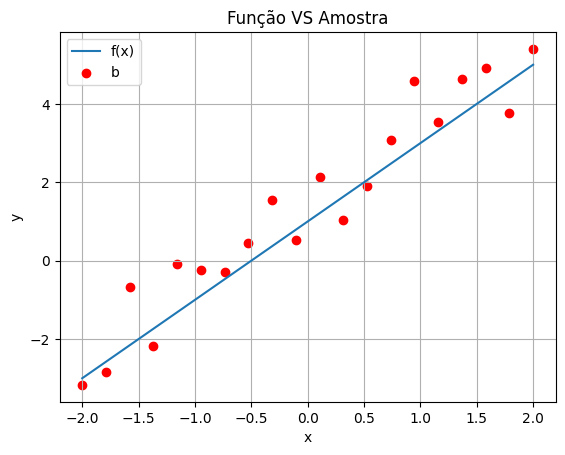

In [3]:
# Verificando graficamente
plt.plot(x, f(x), label='f(x)')
plt.scatter(x, b, color='red', label='b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title("Função VS Amostra")
plt.show()

Como o ruído é normal e pequeno, uma regressão através da norma euclidiana funciona bem.

In [4]:
# funcao para retornar a pseudo-inversa
def pinv(A):
    linhas, colunas = A.shape
    AT = np.zeros((colunas,linhas))
    for i in range(linhas):
        for j in range(colunas):
            AT[j,i] = A[i,j]
            
    try:
        AT_A_inv = np.linalg.inv(AT @ A)
    except Exception as e:
        print("Erro: ",e)
    
    pseudo_A = AT_A_inv @ AT
    
    return pseudo_A

Resolvendo o modelo linear

In [5]:
A = np.column_stack((np.ones_like(b), x))

# modelo f = A * x
coefs = pinv(A) @ b

coefs

array([1.40064989, 2.00670858])

In [6]:
# Erro relativo 
res = pd.DataFrame({
    'f': f(x),
    'f_est': A @ coefs,
    'erro': f(x) - A @ coefs,
    'erro_relativo': (f(x) - A @ coefs) / (A @ coefs)})
res

,f,f_est,erro,erro_relativo
0,-3.000000,-2.612767,-0.387233,0.148208
1,-2.578947,-2.190302,-0.388645,0.177439
2,-2.157895,-1.767837,-0.390057,0.220641
3,-1.736842,-1.345372,-0.391470,0.290975
4,-1.315789,-0.922907,-0.392882,0.425700
5,-0.894737,-0.500442,-0.394294,0.787892
6,-0.473684,-0.077977,-0.395707,5.074628
7,-0.052632,0.344487,-0.397119,-1.152782
8,0.368421,0.766952,-0.398531,-0.519630
9,0.789474,1.189417,-0.399944,-0.336252


Chegou-se a erros muito pequenos

In [7]:
coefs.round(2)

print(f"Fórmula resultante: f(x) = {coefs.round(2)[0]} + {coefs.round(2)[1]}*x")

Fórmula resultante: f(x) = 1.4 + 2.01*x


## Regressão L2

In [8]:
# matriz com as observações
A = np.vstack([np.ones_like(x), x]).T
A.shape
A

array([[ 1.        , -2.        ],
       [ 1.        , -1.78947368],
       [ 1.        , -1.57894737],
       [ 1.        , -1.36842105],
       [ 1.        , -1.15789474],
       [ 1.        , -0.94736842],
       [ 1.        , -0.73684211],
       [ 1.        , -0.52631579],
       [ 1.        , -0.31578947],
       [ 1.        , -0.10526316],
       [ 1.        ,  0.10526316],
       [ 1.        ,  0.31578947],
       [ 1.        ,  0.52631579],
       [ 1.        ,  0.73684211],
       [ 1.        ,  0.94736842],
       [ 1.        ,  1.15789474],
       [ 1.        ,  1.36842105],
       [ 1.        ,  1.57894737],
       [ 1.        ,  1.78947368],
       [ 1.        ,  2.        ]])

Construa sua função de custo para minimizar o erro via normal L2, i.e., a raíz da soma dos quadrados dos erros.

In [9]:
# Retorna um vetor com os erros dado os parâmetros 'coefs'
def error_vector(coefs):
    predictions = A @ coefs
    errors = predictions - f(x)
    return errors

# Retorna a norma L2 de v
def L2_norm(v):
    return np.sqrt(np.sum(v**2))

# F.O.: Raíz quadrada da soma dos quadrados dos erros
def L2_cost(v):
    return L2_norm(error_vector(v))

In [10]:
# Realiza a minimização da função de custo. L2_cost
res = minimize(L2_cost, coefs)
L2_cost_ret = res.x

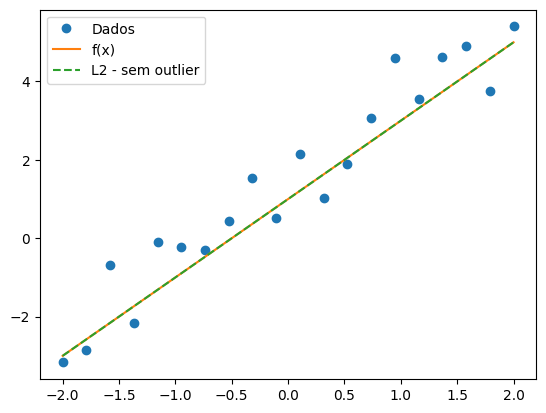

In [11]:
plt.plot(x, b, 'o', label='Dados')
plt.plot(x, f(x), label='f(x)')
plt.plot(x, L2_cost_ret[0] + L2_cost_ret[1]*x, '--', label='L2 - sem outlier')

plt.legend()
plt.show()

Agora vamos adicionar um outlier e ver se a regressão ainda continua a funcionar

In [12]:
# adicionando outlier
b[-1] = -100

A_2 = np.column_stack((np.ones_like(b), x))

# modelo f = A * x
coefs_2 = pinv(A_2) @ b

coefs_2


# Regressão L2 após outlier
res = minimize(L2_cost, coefs_2)
L2_cost_outlier_ret = res.x

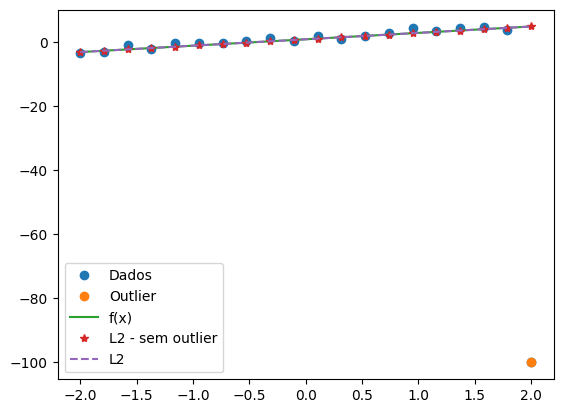

In [13]:
plt.plot(x, b, 'o', label='Dados')
plt.plot(x[-1], b[-1], 'o', label='Outlier')
plt.plot(x, f(x), label='f(x)')
plt.plot(x, L2_cost_ret[0] + L2_cost_ret[1]*x, '*', label='L2 - sem outlier')
plt.plot(x, L2_cost_outlier_ret[0] + L2_cost_outlier_ret[1]*x, '--', label='L2')

plt.legend()
plt.show()

Mesmo com o Outlier, a regressão continua funcionando bem!


Vimos que o método de regularização L1 tem como objetivo promover esparsidade.

**Atenção**: Um detalhe não apresentado em aula é que tipicamente deixamos de fora da regularização L1 o escalar responsável pela translação (intercept), i.e., penalizamos apenas as escolhas das variáveis e não a translação necessária.

Em nosso caso, o escalar é a primeira variável da matriz $A$, assim, a retiramos da regularização.

In [14]:
# Retorna a norma L1 do vetor v
def L1_norm(v):
    norm = 0
    for i in v:
        norm = norm + abs(i)
    return norm

# F.O.: L2 no erro e regularização L1 nos coeficientes, excluindo o intercept
def L2_regL1_cost(v, λ=5):
    return L2_norm(error_vector(v)) + λ*L1_norm(v[1:])

# L2 no erro e regularização L1
res = minimize(L2_regL1_cost, np.array([0, 0]))
L2_regL1_ret = res.x

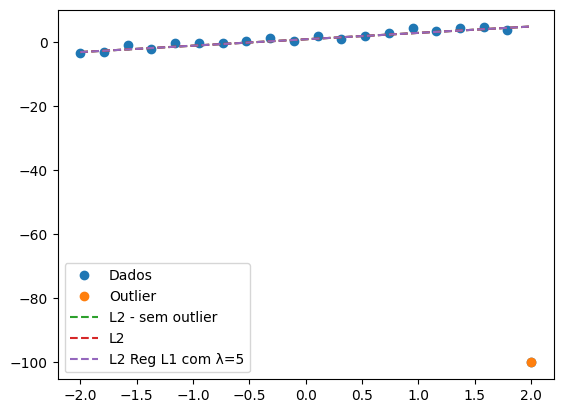

In [15]:
plt.plot(x, b, 'o', label='Dados')
plt.plot(x[-1], b[-1], 'o', label='Outlier')

plt.plot(x, L2_cost_ret[0] + L2_cost_ret[1]*x, '--', label='L2 - sem outlier')
plt.plot(x, L2_cost_outlier_ret[0] + L2_cost_outlier_ret[1]*x, '--', label='L2')
plt.plot(x, L2_regL1_ret[0] + L2_regL1_ret[1]*x, '--', label='L2 Reg L1 com λ=5')

plt.legend()
plt.show()

In [16]:
# F.O.: L1 no erro
def L1_cost(v):
    return L1_norm(error_vector(v))

# L1 no erro
res = minimize(L1_cost, np.array([0, 0]))
L1_ret = res.x

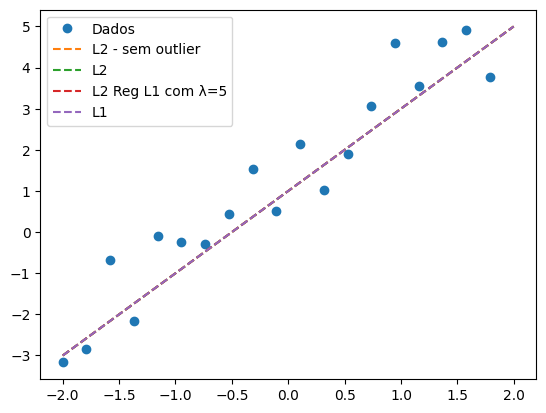

In [17]:
# Para ver melhor os resultados, não mostrado o outlier presente nos dados
plt.plot(x[:-1], b[:-1], 'o', label='Dados')
#plt.plot(x[-1], b[-1], 'o', label='Outlier')

plt.plot(x, L2_cost_ret[0] + L2_cost_ret[1]*x, '--', label='L2 - sem outlier')
plt.plot(x, L2_cost_outlier_ret[0] + L2_cost_outlier_ret[1]*x, '--', label='L2')
plt.plot(x, L2_regL1_ret[0] + L2_regL1_ret[1]*x, '--', label='L2 Reg L1 com λ=5')
plt.plot(x, L1_ret[0] + L1_ret[1]*x, '--', label='L1')

plt.legend()
plt.show()